In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-whitegrid")

In [3]:
RANDOM_SEED = 1234
SPLITS = 5

In [4]:
np.random.seed(RANDOM_SEED)

In [5]:
sst_dataset = load_dataset("imdb")

Found cached dataset imdb (/home/studio-lab-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
sst_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
sst_dataset["train"]["text"][20:21]

['If the crew behind "Zombie Chronicles" ever read this, here\'s some advice guys: <br /><br />1. In a "Twist Ending"-type movie, it\'s not a good idea to insert close-ups of EVERY DEATH IN THE MOVIE in the opening credits. That tends to spoil the twists, y\'know...? <br /><br />2. I know you produced this on a shoestring and - to be fair - you worked miracles with your budget but please, hire people who can actually act. Or at least, walk, talk and gesture at the same time. Joe Haggerty, I\'m looking at you...<br /><br />3. If you\'re going to set a part of your movie in the past, only do this if you have the props and costumes of the time.<br /><br />4. Twist endings are supposed to be a surprise. Sure, we don\'t want twists that make no sense, but signposting the "reveal" as soon as you introduce a character? That\'s not a great idea.<br /><br />Kudos to the guys for trying, but in all honesty, I\'d rather they hadn\'t...<br /><br />Only for zombie completists.']

In [8]:
sst = pd.DataFrame()
sst["text"] = sst_dataset["train"]["text"]
sst["label"] = sst_dataset["train"]["label"]

In [9]:
sst.label.value_counts(normalize=True)

0    0.5
1    0.5
Name: label, dtype: float64

In [10]:
def get_dict_size(text):
    vec = TfidfVectorizer(lowercase=True, ngram_range=(1,1), analyzer="word").fit(text)
    DICT_SIZE = len(vec.get_feature_names_out())
    return DICT_SIZE

In [11]:
DICT_SIZE = get_dict_size(sst["text"])
print(DICT_SIZE)

74849


In [12]:
pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                   LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)
                  )

In [13]:
pl.fit(sst["text"], sst["label"])

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=67364)),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=250, random_state=1234))])

In [14]:
pl.score(sst["text"], sst["label"])

0.91464

In [15]:
cv = StratifiedKFold(n_splits=SPLITS)
cross_validate(pl, sst["text"], sst["label"], cv=cv, scoring={"accuracy", "f1"})

{'fit_time': array([6.61522508, 6.63498664, 5.77560234, 6.50608921, 5.17826986]),
 'score_time': array([0.86991763, 0.87914109, 0.86443377, 0.88865995, 0.8694973 ]),
 'test_f1': array([0.85946259, 0.8638702 , 0.84950375, 0.86736334, 0.86491935]),
 'test_accuracy': array([0.8546, 0.8624, 0.8514, 0.868 , 0.866 ])}

In [16]:
acc_scores = []
f1_scores = []
fold = []
lab_perc = []
i_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
t0  = time.time()
for i in i_range:
    sst["ss_label"] = np.where(sst.index.isin(sst.sample(frac=1-i).index), -1, sst.label)
    ss_pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                          SelfTrainingClassifier(
                          LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)))
    
    for f, (train, test), in zip(range(SPLITS), cv.split(sst["text"], sst["label"])):
        ss_pl.fit(sst["text"][train], sst["ss_label"][train])
        ss_pl_preds = ss_pl.predict(sst["text"][test])
        acc_scores.append(accuracy_score(sst["label"][test], ss_pl_preds))
        f1_scores.append(f1_score(sst["label"][test], ss_pl_preds))
        fold.append(f)
        lab_perc.append(i)

t1 = time.time()
exec_time = t1-t0
print(f"Execution time: {exec_time/60:.3f} minutes")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_s

Execution time: 15.134 minutes


In [17]:
dataset_report = pd.DataFrame({"acc_scores": acc_scores,
                               "f1_scores": f1_scores,
                               "fold_number": fold,
                               "dataset_name": ["imdb_Train"] * len(acc_scores),
                               "classes": [sst["label"].nunique()] * len(acc_scores),
                               "dataset_len": [sst.shape[0]] * len(acc_scores),
                               "percent_labeled_samples": lab_perc,
                                "exec_time_secs_9_runs": [exec_time] * len(acc_scores)})

In [18]:
dataset_report

,acc_scores,f1_scores,fold_number,dataset_name,classes,dataset_len,percent_labeled_samples,exec_time_secs_9_runs
0,0.6942,0.710472,0,imdb_Train,2,25000,0.1,908.014627
1,0.7124,0.726512,1,imdb_Train,2,25000,0.1,908.014627
2,0.6904,0.698481,2,imdb_Train,2,25000,0.1,908.014627
3,0.7052,0.709041,3,imdb_Train,2,25000,0.1,908.014627
4,0.7008,0.706206,4,imdb_Train,2,25000,0.1,908.014627
5,0.7682,0.778606,0,imdb_Train,2,25000,0.2,908.014627
6,0.7850,0.792431,1,imdb_Train,2,25000,0.2,908.014627
7,0.7680,0.770206,2,imdb_Train,2,25000,0.2,908.014627
8,0.7754,0.776606,3,imdb_Train,2,25000,0.2,908.014627
9,0.7724,0.775896,4,imdb_Train,2,25000,0.2,908.014627


<AxesSubplot:xlabel='percent_labeled_samples', ylabel='acc_scores'>

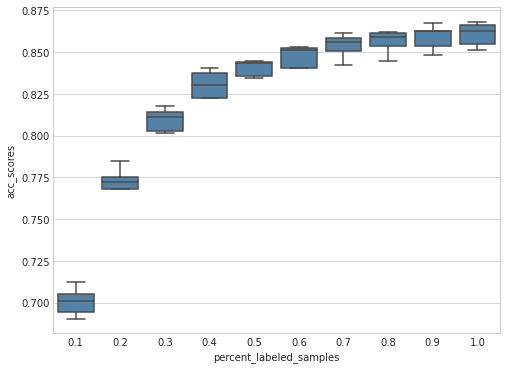

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(data=dataset_report, x="percent_labeled_samples", y="acc_scores", color="steelblue")

In [20]:
dataset_report.to_csv("imdb.csv", index=False)

In [21]:
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# ax[0].scatter(i_range, acc_scores)
# ax[0].plot(i_range, acc_scores)
# ax[0].set_xlabel("Percent of Labeled Samples")
# ax[0].set_ylabel("Accuracy Score")
# ax[0].set_title("% of Labeled Samples Vs Accuracy Score", fontweight="bold")
# ax[1].scatter(i_range, f1_scores)
# ax[1].plot(i_range, f1_scores)
# ax[1].set_xlabel("Percent of Labeled Samples")
# ax[1].set_ylabel("F1 Score")
# ax[1].set_title("% of Labeled Samples Vs F1 Score", fontweight="bold")
# plt.show()